# Introduction:

Ever wondered how google translate works. When we are stuck in some foreign land that doesnt converse in English, the first thing we consider is to use Google translate and try to converse in local language. Translation is the process of converting text or speech from one language into another. Translation is important in many aspects. 

Translation can help in travel and tourism, translation helps in navigating foreign countries, understand their language, converse and understand their customs. 

Translation can also help in Research and Education. When someone has published research in their local language and there is no equivalent in English, translation can help. 

Translation bridges linguistic gaps, fostering communication, understanding, and collaboration among people from different linguistic backgrounds. It is a cornerstone of global interaction, essential for the flow of information and ideas in our increasingly interconnected world. 

There are around 3.6% of world population that converse in French. 

# Data Source:

The data has been published at kaggle. https://www.kaggle.com/datasets/dhruvildave/en-fr-translation-dataset

There are 22,520,736 translated sequences from English to French.

We will use approximately 1,000,000 records for this modelling exercise

# Model:

The idea behind this project was to leverage RNN/LSTM and GRU to do Translation from English to French. This can be leveraged to other languages such as German/Spanish or any other languages. "

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import string
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, TimeDistributed,Bidirectional
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import re
import string
import torch
from tqdm.notebook import tqdm

# Reading CSV file

In [2]:
data = pd.read_csv("../input/en-fr-translation-dataset/en-fr.csv",nrows=50000)

In [3]:
data.head(5)

,en,fr
0,Changing Lives | Changing Society | How It Wor...,Il a transformé notre vie | Il a transformé la...
1,Site map,Plan du site
2,Feedback,Rétroaction
3,Credits,Crédits
4,Français,English


In [4]:
data.shape

(50000, 2)

# Exploratory Data Analysis

# Lets look at certain text pairs

In [5]:
data[data['en']=='Cartoon']

,en,fr
8,Cartoon,Bande dessinée


In [6]:
data[data['en']=='Links']

,en,fr
9,Links,Liens


In [7]:
data[data['en']=='Cartoon']

,en,fr
8,Cartoon,Bande dessinée


# Count the number of words in each row

In [8]:
def count_words(text):
    return len(str(text).split())

data['English_Word_Count'] = data['en'].apply(count_words)
data['French_Word_Count'] = data['fr'].apply(count_words)

In [9]:
data.head(5)

,en,fr,English_Word_Count,French_Word_Count
0,Changing Lives | Changing Society | How It Wor...,Il a transformé notre vie | Il a transformé la...,37,42
1,Site map,Plan du site,2,3
2,Feedback,Rétroaction,1,1
3,Credits,Crédits,1,1
4,Français,English,1,1


#  Checking the Histogram of Word Count - English

<Axes: >

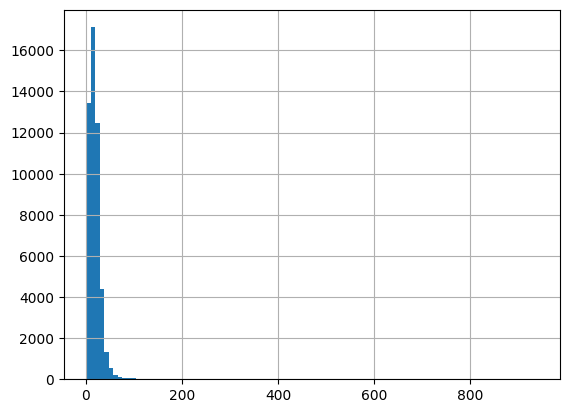

In [10]:
data['English_Word_Count'].hist(bins=100)

# Checking the Word Count - French

<Axes: >

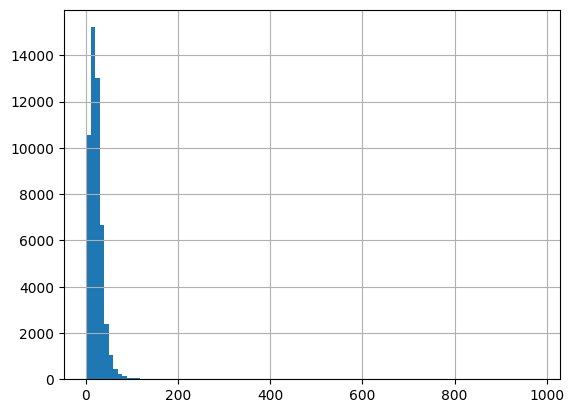

In [11]:
data['French_Word_Count'].hist(bins=100)

In [12]:
data['English_Word_Count'].describe()

count    50000.000000
mean        18.495740
std         14.728359
min          1.000000
25%         10.000000
50%         17.000000
75%         24.000000
max        939.000000
Name: English_Word_Count, dtype: float64

In [13]:
data['French_Word_Count'].describe()

count    50000.000000
mean        22.450640
std         17.730463
min          1.000000
25%         12.000000
50%         20.000000
75%         29.000000
max        979.000000
Name: French_Word_Count, dtype: float64

# Data Preprocessing

1. Converting the data to lower case
2. Removing Punctuation, Apostrophe
3. Removing Digits

In [14]:
data['en'] = data['en'].apply(lambda x: str(x).lower()) # Converting everything to lower 
data['fr'] = data['fr'].apply(lambda x: str(x).lower()) # Converting everything to lower 
data['en'] = data['en'].apply(lambda x: re.sub("'","",x)) # Removing Apostrophe
data['fr'] = data['fr'].apply(lambda x: re.sub("'","",x))# Removing Apostrophe
removal = set(string.punctuation) # Declaring Punctutations
data['en'] = data['en'].apply(lambda x: ''.join(ch for ch in x if ch not in removal)) # Removing Punctuations
data['fr'] = data['fr'].apply(lambda x: ''.join(ch for ch in x if ch not in removal))# Removing Punctuations
digits = str.maketrans('','',string.digits) # Declaring Digits
data['en'] = data['en'].apply(lambda x: x.translate(digits)) # Removing digits from sentences
data['fr'] = data['fr'].apply(lambda x: x.translate(digits))# Removing digits from sentences

In [15]:
data.head(5)

,en,fr,English_Word_Count,French_Word_Count
0,changing lives changing society how it works...,il a transformé notre vie il a transformé la ...,37,42
1,site map,plan du site,2,3
2,feedback,rétroaction,1,1
3,credits,crédits,1,1
4,français,english,1,1


# Background on RNNs:

RNNs are neural networks designed for processing sequences of data, such as time series data or natural language. They are "recurrent" because they perform the same task for every element of a sequence, with the output being dependent on previous computations.
However, RNNs often struggle with long-term dependencies due to problems like vanishing gradients, where the influence of input data diminishes as the gap between relevant information and the point where it's needed grows. There are also Exploding Gradients problem, where the gradients become too big for the RNN and it would become difficult to train. 

# Introduction to LSTM:

LSTM was introduced by Sepp Hochreiter and Jürgen Schmidhuber in 1997 as a solution to the vanishing gradient problem.An LSTM unit is composed of a cell, an input gate, an output gate, and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; each of the three gates regulates the flow of information into and out of the cell.
Key Components of LSTM:

# Cell State: 

This is the core of the LSTM unit. It acts as a kind of conveyor belt, running straight down the entire chain of LSTM layers. It can carry relevant information throughout the processing of the sequence. Thus, information can be easily added or removed to the cell state via gates.

# Input Gate: 

This gate decides what new information is going to be stored in the cell state.

# Forget Gate: 

It determines what information is going to be thrown away from the cell state.

# Output Gate: 

This gate decides what the next hidden state should be, which is used to make predictions or to pass on to the next LSTM cell.

# Applications of LSTM: 

LSTM can be used for Translation, Time Series. 

We are using LSTM for English to French Translation

# Steps Followed For Modeling. 

1. Tokenization
2. Create Train Test Split 70% and 30% - Training and Test Data
3. Fit a LSTM model on Training data and predict on test data.
4. Creating a function to predict for new english word

In [16]:
# Tokenize English sentences
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(data['en'])
eng_seq = eng_tokenizer.texts_to_sequences(data['en'])
eng_seq = pad_sequences(eng_seq, padding='post')

# Tokenize French sentences
fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(data['fr'])
fr_seq = fr_tokenizer.texts_to_sequences(data['fr'])
fr_seq = pad_sequences(fr_seq, padding='post')


In [17]:
eng_train, eng_test, fr_train, fr_test = train_test_split(eng_seq, fr_seq, test_size=0.2)

In [18]:
print("English sequences shape:", eng_train.shape)
print("French sequences shape:", fr_train.shape)
print("French vocabulary size:", len(fr_tokenizer.word_index) + 1)


English sequences shape: (40000, 575)
French sequences shape: (40000, 556)
French vocabulary size: 47390


In [19]:
fr_seq = pad_sequences(fr_seq, maxlen=575, padding='post')


In [20]:
eng_train, eng_test, fr_train, fr_test = train_test_split(eng_seq, fr_seq, test_size=0.2)

In [21]:
print("English sequences shape:", eng_train.shape)
print("French sequences shape:", fr_train.shape)
print("French vocabulary size:", len(fr_tokenizer.word_index) + 1)


English sequences shape: (40000, 575)
French sequences shape: (40000, 575)
French vocabulary size: 47390


In [22]:
model = Sequential()
model.add(Embedding(input_dim=len(eng_tokenizer.word_index)+1, output_dim=256, input_length=eng_seq.shape[1]))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(len(fr_tokenizer.word_index)+1, activation='softmax')))
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy')

In [23]:
model.fit(eng_train, fr_train, batch_size=8, epochs=5, validation_data=(eng_test, fr_test))

Epoch 1/5
5000/5000 [==============================] - 1578s 314ms/step - loss: 0.3177 - val_loss: 0.2679
Epoch 2/5
5000/5000 [==============================] - 1554s 311ms/step - loss: 0.2549 - val_loss: 0.2500
Epoch 3/5
5000/5000 [==============================] - 1554s 311ms/step - loss: 0.2327 - val_loss: 0.2409
Epoch 4/5
5000/5000 [==============================] - 1554s 311ms/step - loss: 0.2145 - val_loss: 0.2376
Epoch 5/5
5000/5000 [==============================] - 1554s 311ms/step - loss: 0.1989 - val_loss: 0.2378


In [24]:
model.save("LSTM.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
def translate(eng_text):
    eng_seq = eng_tokenizer.texts_to_sequences([eng_text])
    eng_seq = pad_sequences(eng_seq, maxlen=eng_train.shape[1], padding='post')
    prediction = model.predict(eng_seq)
    fr_seq = np.argmax(prediction[0], axis=-1)
    fr_text = ' '.join([fr_tokenizer.index_word[i] for i in fr_seq if i > 0])
    return fr_text


In [26]:
new_sentence = "Good Morning"
translated_sentence = translate(new_sentence)
print("Translated:", translated_sentence)


1/1 [==============================] - 0s 405ms/step
Translated: il plus


# Model Insights:

The model is not working as expected. So lets explore Bidirectional LSTM. The difference between LSTM and Bidirectional LSTM is that LSTM looks in a single direction, while Bidirectional LSTM can process sequences in both forward to backward and backward to forward direction. This would enhance the performance of the model. 

# Transformers 

A transformer model is a neural network that learns context and thus meaning by tracking relationships in sequential data like the words in this sentence.

Transformer models apply an evolving set of mathematical techniques, called attention or self-attention, to detect subtle ways even distant data elements in a series influence and depend on each other.

First described in a 2017 paper from Google, transformers are among the newest and one of the most powerful classes of models invented to date. They’re driving a wave of advances in machine learning some have dubbed transformer AI.

Stanford researchers called transformers “foundation models” in an August 2021 paper because they see them driving a paradigm shift in AI. The “sheer scale and scope of foundation models over the last few years have stretched our imagination of what is possible,” they wrote.

In [6]:
# using pretrained model and then finetunig it on our dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-fr").to('cuda')

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/778k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/301M [00:00<?, ?B/s]

In [7]:
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0001)

In [8]:
def model_train():
    model.train()
    losses = 0
    X = df['en']
    y = df['fr']
    max_epochs = 15
    n_batches = 32
    for epoch in tqdm(range(max_epochs)):
        for i in tqdm(range(n_batches)):
            # making batches 
            local_X, local_y = X[i*n_batches:(i+1)*n_batches,], y[i*n_batches:(i+1)*n_batches,]
            # preparing the data according to the model input
            batch = tokenizer.prepare_seq2seq_batch(list(local_X),list(local_y),return_tensors='pt').to('cuda')
            output = model(**batch)
            # loss can be taken directly from the model output
            loss = output.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses = losses+loss
    average = losses/len(df)
    print('Loss: ' + str(average) )
    
    return model

In [9]:
model = model_train()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss: tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


In [10]:
a = model.generate(**tokenizer.prepare_seq2seq_batch(['Good Morning'],return_tensors='pt').to('cuda'))
tokenizer.batch_decode(a)

['<pad> Bonjour']

In [11]:
torch.save(model , 'model.pkl')

# Conclusion:

1. This has been an interesting experiment where I started with trying to understand RNN LSTM can be used for translation. Tried multiple hyperparameters such as Embedding size, LSTM layers, activation function, nothing worked.

2. As a next step tried Bidirectional LSTM, that didnt work as well. Normal LSTM looks at the sequential data either from left to right or right to left, in case of bidirectional LSTM the sequences are looked from both the directions Right to Left and Left to Right. Unfortunately, I couldnt train as I was getting memory error while passing the text. 

3. While reading about translation and exploring about it at Huggingface, came across this model which has been already trained on a large corpus of opus data. 

4. This transformer model provides a much better result when compared to  LSTM model. So it has been used as a final model. 

5. In case of the current project, the only metric that would make sense would be the correct translation of different words.


# References:

1. https://blogs.nvidia.com/blog/what-is-a-transformer-model/

2. https://opus.nlpl.eu/

3.  https://huggingface.co/Helsinki-NLP/opus-mt-en-fr